In [1]:
# NOTES - TAKE 2
# for now, use max captured exposure as zmax, fix later
# obtain pixel value Z from camera with expohttp://192.168.7.2:8888/notebooks/part5_2_hdr.ipynb#sure X, exposure time dt
# want to get irradiance E, given X and dt, E = X / dt
# Z = f(X) = f(E * dt)
# invf(Z) = E * dt
# ln(invf(Z)) = ln(E) + ln(dt)
# g(a) = ln(invf(a)) --> g(Z) = ln(E) + ln(dt)
# ln(E) = g(Z) - ln(dt)
# do this for all Z_ij, E_i, dt_j (pixel i in image j)
# Goal: compute radiance of each pixel, given g, Z, dt

In [2]:
## Initialize everything
import math
%run common.ipynb

Importing libraries...
Done!
Initialize camera and default settings...
Done!
Define functions needed to capture images...
Done!
Generating patterns for projector...
Done!


In [3]:
# globals for debug
global small
global big
global zeros
small = 0
big = 0
zeros = 0

In [29]:
# FUNCTIONS

# return array of images and array of corresponding exposures
def get_images(num_exposures=50):
    # pretend these are exposure times
    exposure_times = []
    tmin = 1
    tmax = 10
    
    # adjust these for better noise reduction
    pixy.set_gamma(1);
    pixy.set_gain(32);
    
    images = []
    # capture images at various exposures (50 evenly spaced vals btwn 1 and 10)
    for x in numpy.linspace(tmin, tmax, num_exposures):
        pixy.set_exposure(x);
        img = get_raw_image();
        img = get_raw_image(); # need to call twice for exposure change to take effect
        images += [img]
        exposure_times += [x]; # x vals
    
    return [images, exposure_times]
    
# return array of pixel values corresponding to exposure times and max pixel value
def get_calibration_curve_from_images(images, p0=100, p1=150):
    pixel_values = []
    # store average pixel value for each image
    max_pixel_value = 0
    for i in range(len(images)):
        img = images[i]
        pixel_values += [numpy.mean(numpy.mean(img[p0:p1,p0:p1]))]; # y vals
        if (pixel_values[-1] > max_pixel_value):
            max_pixel_value = pixel_values[-1]
        
    print("max pixel value=" + str(max_pixel_value))
    return [pixel_values, max_pixel_value]

# add (0,0) to the data set
# maybe add(max_exposure, 255) later?
def fix_ranges(pixel_values, exposure_times):
    pv = []
    pv += [0]
    for z in pixel_values:
        pv += [z]
    et = []
    et += [0]
    for t in exposure_times:
        et += [t]
    return [pv, et]

# maybe use numpy.interp instead?
def lin_interp(x, x0, x1, y0, y1):
    z = (x-x0)/(x1-x0)
    return y0*(z) + y1*(1-z)

# get lowerbounded index in pixel_values that px is close to
def get_bucket(px, pixel_values):
    for j in range(0,len(pixel_values)-1):
        if (pixel_values[j] <= px) and (px <= pixel_values[j+1]):
            return j
    # if out of range, return first or last
    if (px > pixel_values[-1]):
        return len(pixel_values)-1
    else:
        return 0    
    
# Make response curve
# Given pixel values, exposure times, and dataset params
# return function g, g(pixel value) = exposure
# note: exposure = radiance * exposure time
def make_g(pixel_values, exposure_times, num_buckets, zmin, zmax):
    print("num buckets=" + str(num_buckets) + ", zmax=" + str(zmax))
    
    # given pixel value x, returns exposure time
    def finv(x):
        m = get_bucket(x, pixel_values) # bucket based on pixel val
        #print("bucket " + str(m) + ", val=" + str(x))
        if m+1 >= num_buckets: 
            return exposure_times[-1]
        x0 = pixel_values[m]
        x1 = pixel_values[m+1]
        y0 = exposure_times[m]
        y1 = exposure_times[m+1]
        if (x0 >= x1 or y0 > y1):
            print("bad vals") # should be fixed now, but just in case
            return 0
        return lin_interp(x, x0, x1, y0, y1) 
    
    # given pixel value x, returns ln (exposure time)
    def g(x):
        return numpy.log(finv(x))

    # print some curves for sanity
    print("finv: exposure time vs pixel val")
    plot_func(finv, zmin, zmax, num_buckets)
    print("g: ln(exposure time) vs pixel val")
    plot_func(g, zmin, zmax, num_buckets)
    
    return [finv,g]

# make weight function based on zmin and zmax
# clamping vs absolute val of weight vs weight normally
# both abs and normal weight look ok-ish, clamping loses a lot of detail
# using absolute value seems to have better results even though it doesn't make sense that it should?
def make_w(zmin, zmax):
    def w(z):
        # debug things
        global big
        global small
        if (z < zmin):
            small += 1
        if (z > zmax):
            big += 1
        
        # weight stuff
        if (z < 0.5*(zmin + zmax)):
            return numpy.absolute(z - zmin)
            weighted_z = z - zmin
        else:
            weighted_z = zmax - z
        
        #return weighted_z
        return numpy.absolute(weighted_z)
    return w

# High level: given g, Z_ij, dt_j, return ln(E_i)
# Given set of images, set of exposure times, response function g
# return radiance of pixel @ row r, column c
def get_radiance(images, exposure_times, g, w, r, c):
    global zeros
    weighted_exposures = 0
    weights_sum = 0
    height = len(images[0])
    width = len(images[0][0])

    for j in range(0, len(images)):
        dt = exposure_times[j]
        img = images[j]
        z = img[r][c]
        weighted_exposures += w(z)*(g(z) - numpy.log(dt))
        weights_sum += w(z)
    
    # debug stuff
    if (weights_sum == 0):
        zeros += 1
        return 1
        
    lnE = weighted_exposures / weights_sum
    return pow(numpy.e, lnE)

# helper function to plot functions for debugging
def plot_func(f, zmin, zmax, step):
    vals = []
    for x in numpy.linspace(zmin, zmax, step):
        vals += [f(x)]
    plt.plot(vals); plt.show();
    
# convert raw image to color image
def raw2color(raw_image):
    red_image   = raw_image[1::2,1::2];
    green_image = (raw_image[1::2,0::2] + raw_image[0::2,1::2]) / 2.0;
    blue_image  = raw_image[0::2,0::2];
    
    color_image = numpy.dstack((red_image, green_image, blue_image));

    return numpy.uint8(255*color_image);

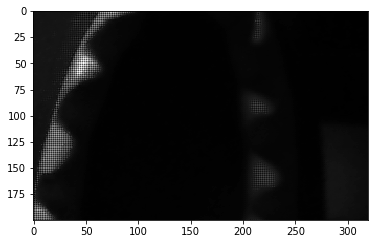

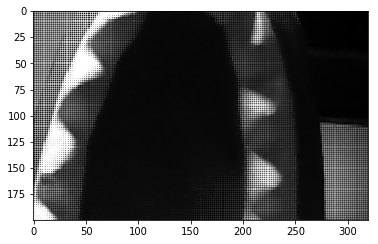

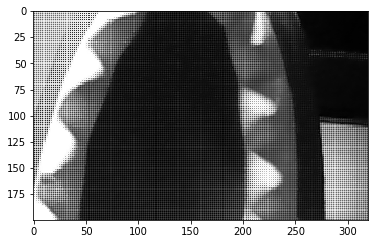

 max pixel value=77.8999385643
pixel_value vs exposure


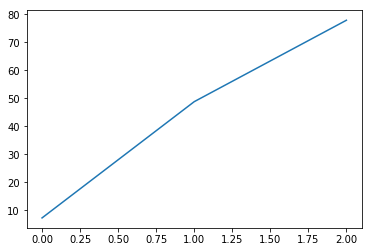

In [20]:
# ALL TOGETHER
num_img = 3;

[images, exposure_times] = get_images(num_img)
plt.imshow(images[0]); plt.show();
plt.imshow(images[1]); plt.show();
plt.imshow(images[2]); plt.show();

#calibration curve
[pixel_values, max_pixel_value] = get_calibration_curve_from_images(images, 0,-1)
print("pixel_value vs exposure"); 
plt.plot(pixel_values);
plt.show();

pixel vals=[7.2661898835872147, 48.80518580362628, 77.899938564294828]
exposure_times=[1.0, 5.5, 10.0]
fixed pixel vals=[0, 7.2661898835872147, 48.80518580362628, 77.899938564294828]
fixed exposure_times=[0, 1.0, 5.5, 10.0]
make g...
num buckets=3, zmax=77.8999385643
finv: exposure time vs pixel val


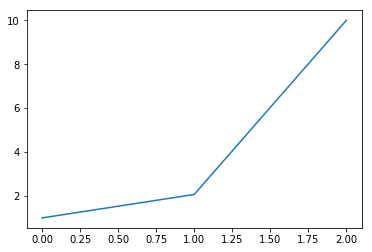

g: ln(exposure time) vs pixel val


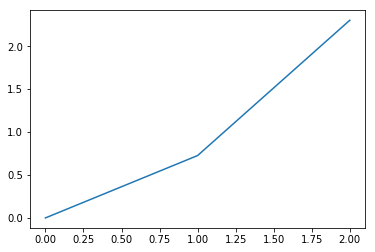

In [21]:
# force function to start at (0,0)
print("pixel vals=" + str(pixel_values))
print("exposure_times=" + str(exposure_times))
[fixed_pixel_values, fixed_exposure_times] = fix_ranges(pixel_values, exposure_times)
print("fixed pixel vals=" + str(fixed_pixel_values))
print("fixed exposure_times=" + str(fixed_exposure_times))

# make resp function
print("make g...")
[finv, resp_func] = make_g(fixed_pixel_values, fixed_exposure_times, num_img, 0, max_pixel_value)

In [22]:
# construct hdr image with g

# weight based on true range of camera capture
w = make_w(0, max_pixel_value)
# w = make_w(0, 255)

new_image = []
image_size = len(images[0])

height = len(images[0] / 10)
width = len(images[0][0] / 10)

spacing = 1

print("start constructing " + str(width/spacing) + "x" + str(height/spacing) + " image")
for r in range(height):
    if (r % spacing != 0): #skip row
        continue
        
    row = []
    for c in range(width):
        # for each pixel
        if (c % spacing != 0):# skip pixel
            continue   
        row += [get_radiance(images, exposure_times, resp_func, w, r, c)]
        
    new_image += [row]
    print(r),

    
print("construction done!")
print("small="+str(small))
print("big="+str(big))
print("zero weight sums="+str(zeros))

start constructing 320x200 image
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 construction done!
small=0
big=160766
zero weight sums=9017


images from g
show clipped img, min=0, max=0.5


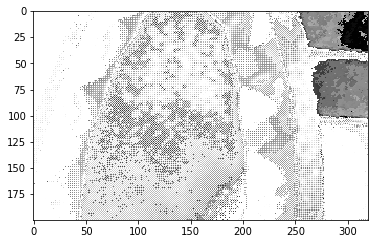

show clipped img, min=0, max=1


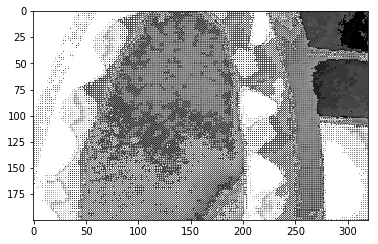

show clipped img, min=0, max=2


In [ ]:
def show_clipped(img, zmin, zmax):
    print("show clipped img, min=" + str(zmin) + ", max=" + str(zmax))
    plt.imshow(numpy.clip(new_image,zmin,zmax)); plt.show();
    
print("images from g")
show_clipped(new_image, 0, 0.5);
show_clipped(new_image, 0, 1);
show_clipped(new_image, 0, 2);
show_clipped(new_image, 0, 5);
show_clipped(new_image, 0, 10);
show_clipped(new_image, 0, 100);
show_clipped(new_image, 0, 1000);
show_clipped(new_image, 0, 100000);

min/max in new image
show clipped img, min=0, max=100


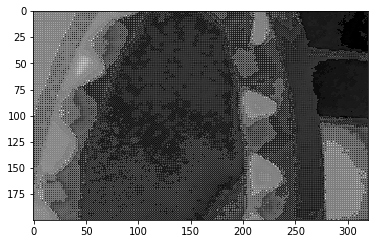

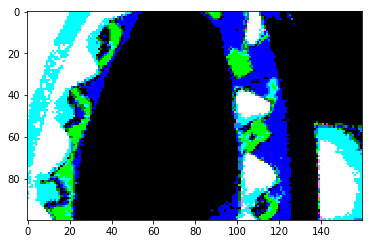

In [30]:
# need to use numpyp array whoops
image = numpy.array(new_image, numpy.int8)
print("min/max in new image")
# print(min(image))
# print(max(image))

show_clipped(raw2color(image), 0, 100);
# color image attempt 1
plt.imshow(raw2color(image))

blue


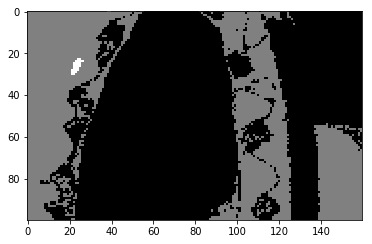

red


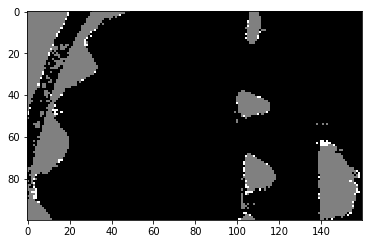

green


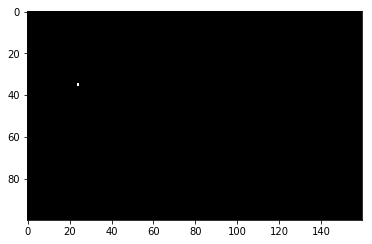

In [34]:
A = image[0::2,0::2];
B = image[0::2,1::2];
C = image[1::2,0::2];
D = image[1::2,1::2];
# color image attempt 2
# show_clipped(color_image, 0, 100000);

# show each color channel
print("blue")
plt.imshow(A); plt.show(); #blue
print("red")
plt.imshow(D); plt.show(); #red
print("green")
plt.imshow(B/2+C/2); plt.show(); #green

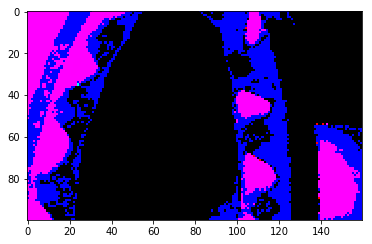

In [37]:
# color image attempt 3
color_image = numpy.dstack((D, (B/2+C/2), A));
plt.imshow(color_image); plt.show();